# Environment Setup

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

In [ ]:
%cd /content/drive/MyDrive/CS5228_Project

# Data Preprocessing

## 1. Load in the dataset and remove unnecessary columns

In [1]:
import pandas as pd

def load_data(path):
    """
    Remove the features that:
      1. may not be so useful for the model
      2. have too many missing values
      3. all the values are the same
      4. may be redundant with other features
    """
    df = pd.read_csv(path)
    df.drop(["indicative_price", "eco_category", "opc_scheme", "lifespan"], axis=1, inplace=True)
    return df


df_train = load_data("data/train.csv")
df_test = load_data("data/test.csv")

## 2. Process date features

In [2]:
def proce_date(df):
    """
    Convert the date imformation from string to duration numerical number
    """
    # Convert date columns to datetime
    df["reg_date"] = pd.to_datetime(df["reg_date"], format="%d-%b-%Y")
    df["original_reg_date"] = pd.to_datetime(df["original_reg_date"], format="%d-%b-%Y")

    # Calculate age of vehicle
    end_date = pd.to_datetime("2024-11-01")
    reg_age = round(((end_date - df["reg_date"]).dt.days / 365.25), 2)

    # Fill missing values in manufactured column
    df.loc[df["category"].str.contains("parf car"), "manufactured"] = df.loc[
        df["category"].str.contains("parf car"), "manufactured"
    ].fillna(df["reg_date"].dt.year)

    # Fill missing values in manufactured column
    df.loc[df["manufactured"].isna(), "manufactured"] = (
        df.loc[df["manufactured"].isna(), "manufactured"]
        .fillna(df["original_reg_date"].dt.year)
        .fillna(df["reg_date"].dt.year)
    )
    df["manufactured"] = 2024 - df["manufactured"]

    # Drop and rename columns
    df["reg_date"] = reg_age
    df.rename(columns={"reg_date": "reg_age"}, inplace=True)
    df.drop(["original_reg_date"], axis=1, inplace=True)

    return df

df_train = proce_date(df_train)
df_test = proce_date(df_test)

## 3. Fill the missing `fuel_type` feature

In [3]:
# check for unseen fuel type
unseen_fuel = set(df_test["fuel_type"].unique()) - set(df_train["fuel_type"].unique())
print(len(unseen_fuel))

0


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_distribution(df_train, df_test, feature_name, feature_labels=None):
    """
    Plots the distribution of a feature (e.g., 'fuel_type') across training and testing datasets.

    Parameters:
    - df_train: The training dataset (DataFrame).
    - df_test: The testing dataset (DataFrame).
    - feature_name: The feature name (column) for which to plot the distribution.
    - feature_labels: Optional dictionary with custom labels for the feature values.

    Returns:
    - None
    """
    # Calculate the feature value counts as percentages for both train and test sets
    train_feature_counts = df_train[feature_name].value_counts(normalize=True) * 100
    test_feature_counts = df_test[feature_name].value_counts(normalize=True) * 100

    # Combine the results into a single DataFrame
    combined_feature_counts = pd.DataFrame({
        f'{feature_name}_train_percentage': train_feature_counts,
        f'{feature_name}_test_percentage': test_feature_counts
    }).fillna(0)

    # Reset the index to use feature values as a column for plotting
    combined_feature_counts.reset_index(inplace=True)
    combined_feature_counts.columns = [feature_name, f'{feature_name}_train_percentage', f'{feature_name}_test_percentage']

    # Melt the DataFrame for plotting
    melted_df = combined_feature_counts.melt(id_vars=feature_name, value_vars=[f'{feature_name}_train_percentage', f'{feature_name}_test_percentage'],
                                             var_name='Dataset', value_name='Percentage')

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_name, y='Percentage', hue='Dataset', data=melted_df)

    # Customize the plot
    plt.title(f'{feature_name.capitalize()} Distribution: Train vs Test', fontsize=16)
    plt.xlabel(feature_name.capitalize(), fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)

    if feature_labels:
        plt.xticks(ticks=range(len(feature_labels)), labels=[feature_labels.get(val, val) for val in combined_feature_counts[feature_name]])
    else:
        plt.xticks(rotation=45)

    plt.tight_layout()

    # Show the plot
    plt.show()

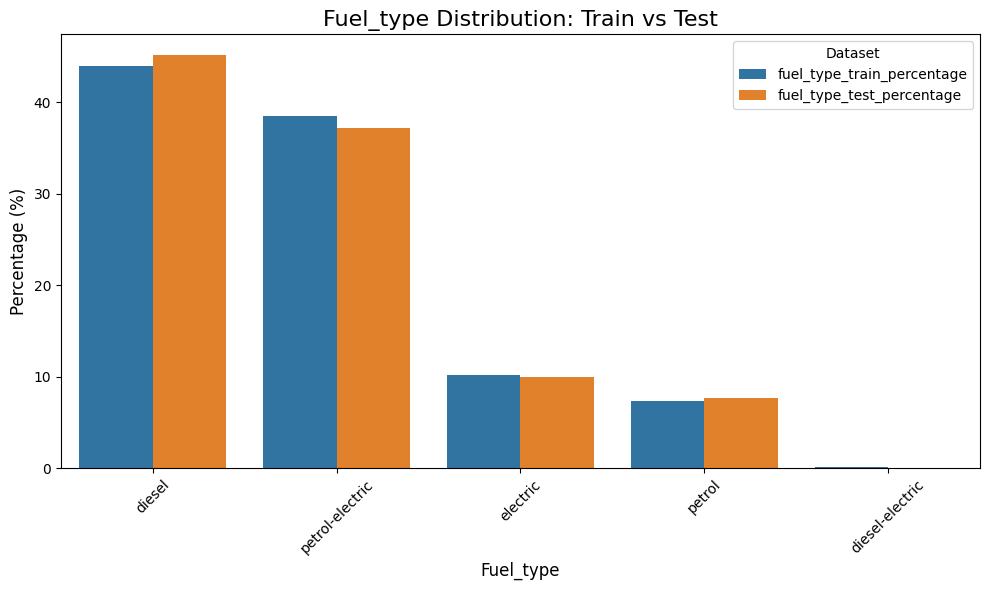

In [5]:
# plotting the distributions before imputation
plot_feature_distribution(df_train, df_test, 'fuel_type')

In [6]:
# diesel is very frequent in this dataset, eventhough that is not the case in the population distribution by fuel type across singapore
# let's take a closer look at the distribution in this dataset

def analyze_diesel_distribution(df_train, df_test):
    # Filter for diesel vehicles in both train and test sets
    train_diesel = df_train[df_train["fuel_type"].str.lower() == "diesel"]
    test_diesel = df_test[df_test["fuel_type"].str.lower() == "diesel"]

    # Group by type_of_vehicle and count occurrences in each dataset
    train_diesel_dist = (
        train_diesel.groupby("type_of_vehicle")["fuel_type"]
        .count()
        .reset_index(name="train_count")
    )
    test_diesel_dist = (
        test_diesel.groupby("type_of_vehicle")["fuel_type"]
        .count()
        .reset_index(name="test_count")
    )

    # Merge results for side-by-side comparison
    diesel_distribution = pd.merge(
        train_diesel_dist, test_diesel_dist, on="type_of_vehicle", how="outer"
    ).fillna(0)

    return diesel_distribution.sort_values(by="train_count", ascending=False)

# Usage
diesel_distribution_df = analyze_diesel_distribution(df_train, df_test)
diesel_distribution_df

,type_of_vehicle,train_count,test_count
8,truck,939,389
9,van,625,274
4,mpv,275,101
1,hatchback,201,72
7,suv,198,84
0,bus/mini bus,197,78
2,luxury sedan,108,42
3,mid-sized sedan,26,17
6,stationwagon,13,3
5,sports car,4,1


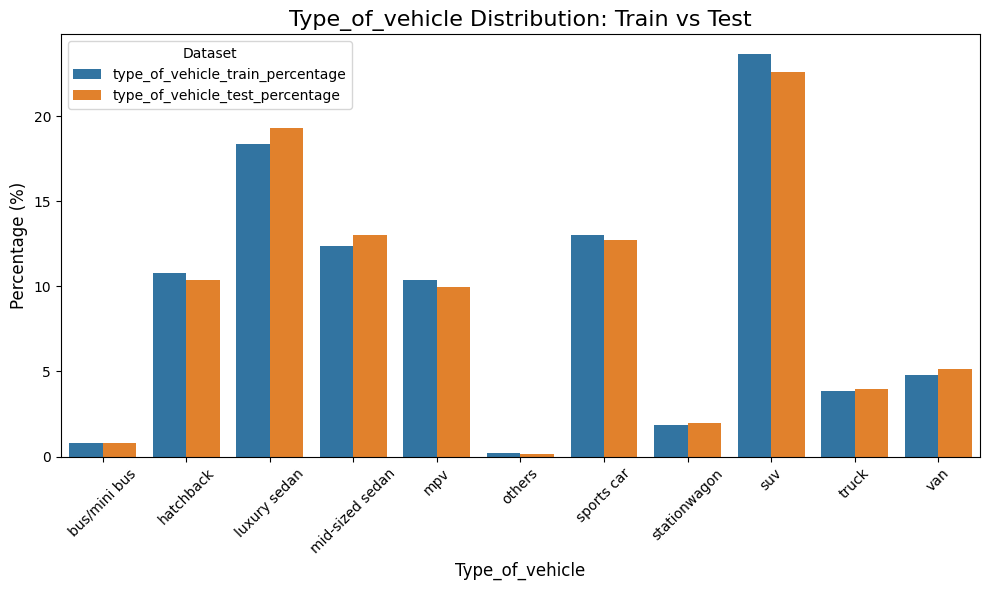

In [7]:
plot_feature_distribution(df_train, df_test, 'type_of_vehicle')

In [8]:
def build_condition(df, columns, keywords):
    """
    Build a condition to check if any of the keywords are present in specified columns.

    Parameters:
    - df: DataFrame to search within
    - columns: list of column names to search
    - keywords: list of keywords to search for

    Returns:
    - Boolean Series representing the condition
    """
    condition = None
    keyword_pattern = "|".join(keywords)  # Create a regex pattern from keywords

    # Loop through each column and build conditions
    for col in columns:
        col_condition = df[col].str.lower().str.contains(keyword_pattern, na=False)
        condition = col_condition if condition is None else condition | col_condition

    return condition

def process_fuel_type(df):
    # Define lists of keywords for different fuel types
    hybrid_keywords = ["hybrid", "hybrid engine"]
    misleading_hybrid_kw = ["hybrid turbo", "hybrid racing"]

    # Define columns to search within
    free_text_columns = ["title", "features", "description", "category"]

    # Build the conditions using the new function
    hybrid_freetext = build_condition(df, ["features", "description"], ["hybrid"])
    hybrid_indicators = (build_condition(df, ["title", "category"], ["hybrid"]) | build_condition(df, ["features", "description"], ["hybrid engine","hybrid-engine"]))
    petrol_condition = build_condition(df, free_text_columns, ["petrol"])
    diesel_condition = build_condition(df, free_text_columns, ["diesel"])
    diesel_electric_condition = build_condition(df, free_text_columns, ["diesel electric", "diesel-electric"])
    petrol_electric_condition = build_condition(df, free_text_columns, ["petrol electric", "petrol-electric"])

    # Identify misleading hybrid entries, i.e. building a blacklist of non-hybrid entries listing ids
    potential_hybrid = df[hybrid_freetext & ~hybrid_indicators]
    misleading_hybrid_condition = build_condition(potential_hybrid, ["features", "description"], misleading_hybrid_kw)
    non_hybrid = potential_hybrid[misleading_hybrid_condition]

    # Define main hybrid, diesel, and electric conditions
    hybrid_condition = (hybrid_freetext | hybrid_indicators) & ~(
        df["listing_id"].isin(non_hybrid["listing_id"])
    )
    electric_indicators = build_condition(df, ["title", "category"], ["electric"])

    # printing out the count before filling in
    print(f"# of non-hybrid vehicles with keyword hybrid: {non_hybrid.shape[0]}")
    print(f"# of vehicles with diesel-electric keyword with nan fuel type: {df.loc[diesel_electric_condition & (df['fuel_type'].isna())].shape[0]}")
    print(f"# of vehicles with electric keyword with nan fuel type: {df.loc[electric_indicators & (df['fuel_type'].isna())].shape[0]}")
    print(f"# of vehicles with diesel keyword with nan fuel type: {df.loc[diesel_condition & (df['fuel_type'].isna())].shape[0]}")
    print(f"# of vehicles with petrol-electric keyword with nan fuel type: {df.loc[(hybrid_condition | petrol_condition | petrol_electric_condition)& df['fuel_type'].isna()].shape[0]}")

    # Assign fuel types based on conditions
    df.loc[electric_indicators & (df["fuel_type"].isna()), "fuel_type"] = "electric"
    df.loc[diesel_condition & df["fuel_type"].isna(), "fuel_type"] = "diesel"
    df.loc[diesel_electric_condition & df["fuel_type"].isna(),
        "fuel_type",
    ] = "diesel-electric"
    df.loc[
        (hybrid_condition | petrol_condition | petrol_electric_condition)
        & df["fuel_type"].isna(),
        "fuel_type",
    ] = "petrol-electric"

    # Fill any remaining NaNs with "petrol"
    df["fuel_type"] = df["fuel_type"].fillna("petrol")

    return df

# Apply to both train and test datasets
print("###Training###")
df_train = process_fuel_type(df_train)
print("\n###Testing###")
df_test = process_fuel_type(df_test)


###Training###
# of non-hybrid vehicles with keyword hybrid: 26
# of vehicles with diesel-electric keyword with nan fuel type: 0
# of vehicles with electric keyword with nan fuel type: 2
# of vehicles with diesel keyword with nan fuel type: 7
# of vehicles with petrol-electric keyword with nan fuel type: 272

###Testing###
# of non-hybrid vehicles with keyword hybrid: 8
# of vehicles with diesel-electric keyword with nan fuel type: 0
# of vehicles with electric keyword with nan fuel type: 0
# of vehicles with diesel keyword with nan fuel type: 4
# of vehicles with petrol-electric keyword with nan fuel type: 107


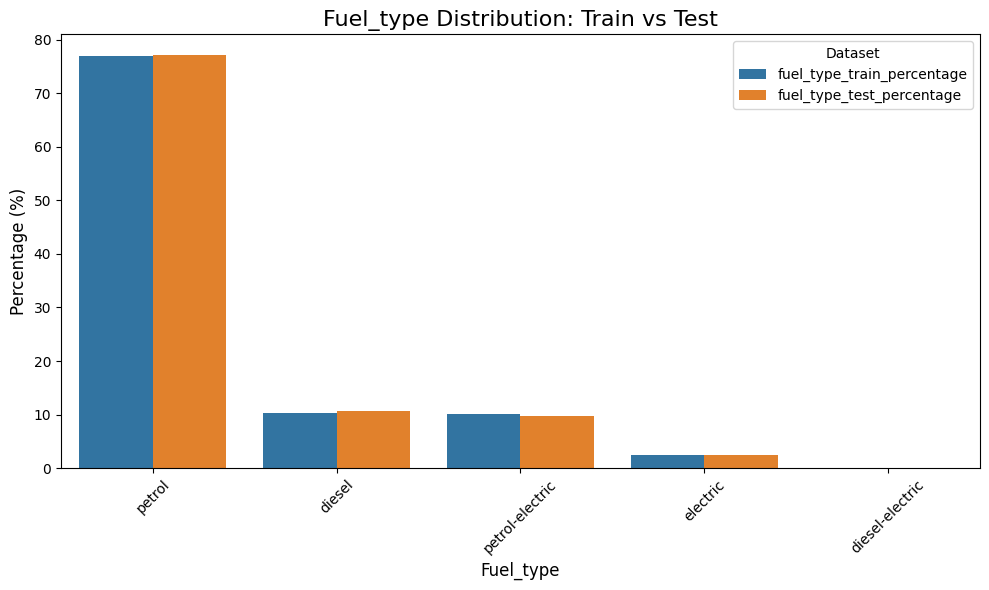

In [9]:
# plotting the distribution after imputation
plot_feature_distribution(df_train, df_test, 'fuel_type')

In [10]:
# complete the ground truth stats for comparison and insights
# https://www.lta.gov.sg/content/dam/ltagov/who_we_are/statistics_and_publications/statistics/pdf/MVP01-4_MVP_by_fuel.pdf

data = {
    'Year': [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'Petrol': [612654, 605511, 587900, 578977, 574443, 569673, 574967, 572132, 568376, 558729, 540605],
    'Diesel': [1412, 3206, 5976, 10364, 15514, 17253, 18049, 18076, 18136, 18261, 18037],
    'Petrol-Electric': [5020, 5727, 6371, 10075, 20751, 27179, 35718, 41845, 54820, 65882, 79256],
    'Petrol-Electric (Plug-In)': [None, 47, 108, 125, 206, 380, 473, 552, 692, 1101, 1359],
    'Petrol-CNG': [2253, 2100, 1932, 1682, 1006, 386, 250, 202, 164, 143, 85],
    'CNG': [None, None, None, None, None, None, None, None, None, None, None],
    'Electric': [None, 1, 1, 12, 314, 560, 1120, 1217, 2942, 6531, 11941],
    'Diesel-Electric': [6, 17, 23, 22, 22, 21, 19, 18, 20, 19, 18],
    'Diesel-Electric (Plug-In)': [None, None, None, None, None, None, None, None, None, 1, 1],
    'Total': [621345, 616609, 602311, 601257, 612256, 615452, 630596, 634042, 645150, 650667, 651302]
}

# Create a DataFrame
stats = pd.DataFrame(data, index=data['Year']).drop(columns=['Year'])

stats = stats.fillna(0)

stats["Petrol-Electric"] = stats["Petrol-Electric"] + stats["Petrol-Electric (Plug-In)"]
stats["Diesel-Electric"] = stats["Diesel-Electric"] + stats["Diesel-Electric (Plug-In)"]

stats.drop(columns=["Petrol-Electric (Plug-In)", "Diesel-Electric (Plug-In)"], inplace=True)

stats["Petrol-Electric"] = stats["Petrol-Electric"].astype(int)
stats["Diesel-Electric"] = stats["Diesel-Electric"].astype(int)
stats["Electric"] = stats["Electric"].astype(int)

# Calculate percentage for each fuel type
stats_percentage = stats.copy()
for column in stats.columns[:]:
    stats_percentage[column] = round((stats[column] / stats['Total']) * 100, 2)

lta_stats = stats_percentage.mean().reset_index().rename(columns={"index":"fuel_type", 0:"lta_stats"})
lta_stats["fuel_type"] = lta_stats["fuel_type"].str.lower()

C:\Users\Klasnov\AppData\Local\Temp\ipykernel_5712\470350694.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stats = stats.fillna(0)


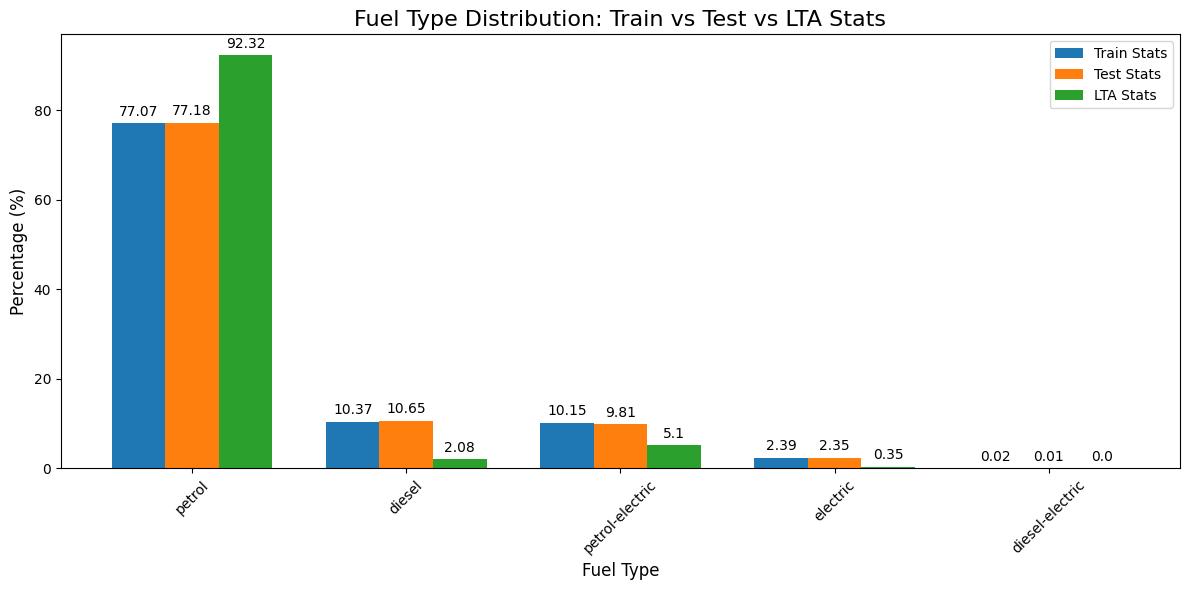

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comparison_side_by_side_with_labels(df_train, df_test, lta_stats):
    """
    Plots a side-by-side bar chart comparing postprocessed stats (df_train and df_test) vs LTA stats for each fuel type,
    with labels showing the values on top of each bar.

    Parameters:
    - df_train: DataFrame containing the training dataset.
    - df_test: DataFrame containing the testing dataset.
    - lta_stats: DataFrame containing LTA statistics.

    Returns:
    - None
    """
    # Extract fuel type proportions from df_train and df_test
    train_stats = df_train['fuel_type'].value_counts(normalize=True) * 100
    test_stats = df_test['fuel_type'].value_counts(normalize=True) * 100

    # Merge the stats into a single DataFrame
    comparison_df = pd.DataFrame({
        'fuel_type': train_stats.index,
        'train_stats': train_stats.values,
        'test_stats': test_stats.values
    }).fillna(0)

    # Merge with LTA stats (ensure consistency in fuel type names)
    comparison_df = comparison_df.merge(lta_stats, on='fuel_type', how='left')

    # Set up the figure and axis
    plt.figure(figsize=(12, 6))

    # Set the width of the bars
    bar_width = 0.25

    # Set the positions of the bars for train_stats, test_stats, and lta_stats
    indices = np.arange(len(comparison_df))  # Position of each fuel type on the x-axis
    train_pos = indices - bar_width  # Shift train stats to the left
    test_pos = indices  # Test stats in the center
    lta_pos = indices + bar_width  # Shift LTA stats to the right

    # Plot the train_stats, test_stats, and lta_stats as bars
    bars_train = plt.bar(train_pos, comparison_df['train_stats'], width=bar_width, label='Train Stats')
    bars_test = plt.bar(test_pos, comparison_df['test_stats'], width=bar_width, label='Test Stats')
    bars_lta = plt.bar(lta_pos, comparison_df['lta_stats'], width=bar_width, label='LTA Stats')

    # Add value labels on top of the bars
    for bar in bars_train:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, round(yval, 2), ha='center', va='bottom', fontsize=10)

    for bar in bars_test:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, round(yval, 2), ha='center', va='bottom', fontsize=10)

    for bar in bars_lta:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, round(yval, 2), ha='center', va='bottom', fontsize=10)

    # Add labels and title
    plt.title('Fuel Type Distribution: Train vs Test vs LTA Stats', fontsize=16)
    plt.xlabel('Fuel Type', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)

    # Set x-axis ticks to be in the center of the bars
    plt.xticks(indices, comparison_df['fuel_type'], rotation=45)

    # Add legend
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_comparison_side_by_side_with_labels(df_train, df_test, lta_stats)


## 4. Encode and embed the basic information

### 4.1 Encoded `type_of_Vehicle`, `fuel_type` and `transmission` features using numerical encoding

In [12]:
tran_train = list(df_train["transmission"].unique())
tran_map = {t: i for i, t in enumerate(tran_train)}


def encode_type_trans(df_train, df_test):
    """
    Encode the type of vehicle and transmission into numerical values
    """
    # transmission
    df_train["transmission"] = df_train["transmission"].map(tran_map)
    df_test["transmission"] = df_test["transmission"].map(tran_map)
    # type of vehicle
    type_mean = df_train.groupby("type_of_vehicle")["price"].mean()
    df_train["type_of_vehicle"] = df_train["type_of_vehicle"].map(type_mean)
    df_test["type_of_vehicle"] = df_test["type_of_vehicle"].map(type_mean)
    # fuel type
    fuel_mean = df_train.groupby("fuel_type")["price"].mean()
    df_train["fuel_type"] = df_train["fuel_type"].map(fuel_mean)
    df_test["fuel_type"] = df_test["fuel_type"].map(fuel_mean)
    return df_train, df_test


df_train, df_test = encode_type_trans(df_train, df_test)

### 4.2 Encode the `category` feature

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

def multi_label_category(df):
    """
    Convert the category feature into multi-label format
    """
    df.loc[:, "category_list"] = df["category"].apply(lambda x: x.split(', '))
    mlb = MultiLabelBinarizer()
    category_encoded = mlb.fit_transform(df["category_list"])
    category_df = pd.DataFrame(category_encoded, columns=mlb.classes_)
    pca = PCA(n_components=3)
    category_df = pca.fit_transform(category_df)
    category_df = pd.DataFrame(category_df, columns=[f"category_{i}" for i in range(3)])
    df = pd.concat([df, category_df], axis=1)
    df.drop(["category", "category_list"],
            axis=1, inplace=True)
    return df


df_train = multi_label_category(df_train)
df_test = multi_label_category(df_test)

### 4.3 Embed the `make` and `model` information

In [14]:
def fill_make(df):
    """
    Fill the missing make values by extracting the make from the title
    """

    missing_make = df["make"].isnull()

    make_list = df["make"].unique()
    make_list = [str(make) for make in make_list]
    
    def extract_make(title):
        # Extract the make from the title
        potential_make = title.split(" ")[0].lower()
        make = None
        for item in make_list:
            if potential_make in item:
                make = item
                break
        return make
    
    df.loc[missing_make, "make"] = df.loc[missing_make, "title"].apply(extract_make)

    df.drop(["listing_id"], axis=1, inplace=True)

    return df

df_train = fill_make(df_train)
df_test = fill_make(df_test)

In [15]:
make_train = set(df_train["make"].unique())
make_test = set(df_test["make"].unique())

unseen_train = make_test - make_train
unseen_test = make_train - make_test

# Change the make "maybach" in the test set to "mercedes-benz"
df_test["make"] = df_test["make"].replace("maybach", "mercedes-benz")

# Change all the other unseen makes to "other", both in the train and test sets
df_train.loc[df_train["make"].isin(unseen_test), "make"] = "other"
df_test.loc[df_test["make"].isin(unseen_train), "make"] = "other"

In [16]:
def encode_make_model(df_train, df_test):
    """
    Encode both make and model features using target encoding with the mean of the `price` feature.
    """
    # Calculate the mean price for each (make, model) combination in df_train
    make_model_mean = df_train.groupby(["make", "model"])["price"].mean()
    
    # Encode the make and model in both df_train and df_test based on make_model_mean
    df_train["model_encoded"] = df_train.set_index(["make", "model"]).index.map(make_model_mean)
    df_test["model_encoded"] = df_test.set_index(["make", "model"]).index.map(make_model_mean)
    
    # Handle missing model matches in df_test by using the mean price for each make
    make_mean = df_train.groupby("make")["price"].mean()
    
    # Fill missing model encodings in df_test with mean price of each make
    df_test["model_encoded"] = df_test["model_encoded"].fillna(df_test["make"].map(make_mean))
    
    #  Finally, encode `make` alone as a fallback (only for unmatched makes in `df_test`)
    df_train["make_encoded"] = df_train["make"].map(make_mean)
    df_test["make_encoded"] = df_test["make"].map(make_mean)

    df_train.drop(["title", "make", "model"], axis=1, inplace=True)
    df_test.drop(["title", "make", "model"], axis=1, inplace=True)
    
    return df_train, df_test

# Apply the encoding function
df_train, df_test = encode_make_model(df_train, df_test)

### 4.4 Extract key information in free texts

In [17]:
def extract_free_text(df):
    # Define keywords for each column
    description_keywords = {
        'owner_info': r'(?:1 owner|single owner|2 owners)',
        'low_mileage': r'(?:low mileage|genuine low mileage|\b\d+\s?(?:km|miles)\b)',
        'maintenance_record': r'(?:no repairs needed|wear and tear done up|accident free|well maintained)',
        'financing_options': r'(?:high loan|full loan available|in-house loan|bank loan)',
        'warranty_info': r'(?:under warranty|warranty till \d{4}|extended warranty available)',
        'vehicle_condition': r'(?:pristine condition|excellent condition|accident free|brand new paintwork|clean interior)',
        'vehicle_features': r'(?:sunroof|leather seats|infotainment system|sport rims|premium interior)',
        'vehicle_type_specs': r'(?:MPV|SUV|sedan|turbo engine|\d+\.\d+L engine)',
        'fuel_efficiency': r'(?:fuel efficient|good fuel consumption|\d+km/L)',
        'maintenance_insurance': r'(?:fully serviced|service record|insurance available|maintenance records)'
    }

    features_keywords = {
        'engine_specs': r'(?:\d+\.\d+L|V6|4 Cylinder Inline|Twin Turbo|DOHC VVT)',
        'power_torque': r'(?:\d+bhp|\d+Nm)',
        'transmission': r'(?:\d+ Speed|7g-Tronic|ZF)',
        'drive_type': r'(?:FWD|AWD|RWD)',
        'safety_airbags': r'(?:SRS Airbags)',
        'anti_lock_brakes': r'(?:ABS|Traction Control)',
        'cruise_control': r'(?:Cruise Control|Adaptive Cruise Control)',
        'collision_lane_assist': r'(?:Lane Departure Warning|Collision Prevention Assist)',
        'fuel_efficiency': r'(?:\d+km/L)',
        'other_features': r'(?:Keyless Entry|Paddle Shifters|Auto Headlights|Sunroof|Electric Tailgate)'
    }

    accessories_keywords = {
        'seat_features': r'(?:leather seats|memory seats|ventilated seats|electric seats|adjustable seats)',
        'entertainment': r'(?:audio system|bluetooth|Apple CarPlay|Android Auto|navigation|GPS|touchscreen|infotainment system)',
        'climate_control': r'(?:rear aircon|climate control|dual-zone climate control|air conditioning)',
        'camera_sensors': r'(?:reverse camera|front/rear camera|360 camera|parking sensors|blind spot monitor)',
        'driving_assist': r'(?:cruise control|paddle shifters|multi-function steering|heads-up display)',
        'wheels_rims': r'(?:sports rims|alloy rims|forged wheels|\d+" rims)',
        'roof_sunroof': r'(?:sunroof|panoramic roof|moonroof)',
        'body_kit': r'(?:body kit|spoiler|carbon fiber|side skirts)',
        'lighting_system': r'(?:LED headlights|daytime running lights|fog lights|xenon headlights)',
        'assist_features': r'(?:lane keeping assist|collision warning|adaptive cruise control|park assist|lane departure alert)',
        'brakes_suspension': r'(?:big brake kit|Brembo brakes|adaptive suspension|coilover|shock absorbers)',
        'keyless_trunk': r'(?:keyless entry|push start|remote start|electric tailgate|power tailgate|auto tailgate)',
        'ambient_lighting': r'(?:ambient lighting|premium upholstery|interior lighting)'
    }
    
    # Helper function to apply keyword matching and create binary columns
    def apply_keyword_flags(df, column_name, keyword_dict):
        # include pca to reduce the dimensionality of the features
        pca = PCA(n_components=3)
        keyword_df = pd.DataFrame()
        for feature_name, pattern in keyword_dict.items():
            # Create a binary column for each feature based on presence of keyword pattern
            keyword_df[f'{column_name}_{feature_name}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int)
        keyword_df = pca.fit_transform(keyword_df)
        keyword_df = pd.DataFrame(keyword_df, columns=[f"{column_name}_pca_{i}" for i in range(3)])
        df = pd.concat([df, keyword_df], axis=1)
        return df

    # Apply the helper function to each column with its respective keyword dictionary
    df = apply_keyword_flags(df, "description", description_keywords)
    df = apply_keyword_flags(df, "features", features_keywords)
    df = apply_keyword_flags(df, "accessories", accessories_keywords)

    # Drop the original text columns
    df.drop(["description", "features", "accessories"], axis=1, inplace=True)

    return df

df_train = extract_free_text(df_train)
df_test = extract_free_text(df_test)

### 4.5 Save the basic features encoded dataset to new CSV files

In [18]:
df_train.to_csv("data/train_basic_encoded.csv", index=False)
df_test.to_csv("data/test_basic_encoded.csv", index=False)

## Exploration: extracting highly related features for prediction

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_train = pd.read_csv("data/train_basic_encoded.csv")
df_test = pd.read_csv("data/test_basic_encoded.csv")

def plot_correlation_matrix(df):
    """
    Plots a heatmap of the correlation matrix for the given DataFrame.

    Parameters:
    - df: The DataFrame containing the data.

    Returns:
    - None
    """
    # Calculate the correlation matrix for the numerical features
    correlation_matrix = df.corr()

    # Set the style for the plot
    sns.set(style="whitegrid")

    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.75})

    # Customize the plot
    plt.title('Correlation Matrix', fontsize=16)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage (replace df_train with your actual DataFrame):
plot_correlation_matrix(df_train)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_correlation_scores_with_minimum(df, min_value=0.1, exponent=4):
    """
    Normalize the correlation scores to a range between min_value and 1.

    Parameters:
    - correlation_list: List of tuples (feature_name, correlation_score).
    - min_value: The minimum value that should correspond to no extra weightage (default is 0.5).

    Returns:
    - A dictionary with feature names as keys and normalized correlation scores as values.
    """
    # Compute the correlation matrix
    corr_matrix = df.corr()

    # Get the indices of the upper triangle of the correlation matrix (excluding diagonal)
    upper_triangle_indices = np.triu_indices_from(corr_matrix, k=1)

    # Find feature pairs with correlation greater than the threshold
    highly_correlated = [
        (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
        for i, j in zip(*upper_triangle_indices)]

    # Flatten the list of feature pairs and their correlation scores
    flat_list = [(feature, corr_score) for feature, _, corr_score in highly_correlated]

    # Extract the correlation scores
    correlation_scores = [score for _, score in flat_list]

    # Reshape for MinMaxScaler
    correlation_scores = np.array(correlation_scores).reshape(-1, 1)

    # Initialize MinMaxScaler to normalize between 0 and 1
    scaler = MinMaxScaler()
    normalized_scores = scaler.fit_transform(correlation_scores).flatten()

    # Apply exponent to increase separation and adjust to min_value
    adjusted_scores = min_value + ((normalized_scores ** exponent) * (1 - min_value))

    # Create the normalized feature-weight dictionary
    normalized_weights = {feature: round(adjusted_score,4) for (feature, _), adjusted_score in zip(flat_list, adjusted_scores)}

    return normalized_weights

# Normalize the correlation scores with a minimum value of 0.5
normalized_weights = normalize_correlation_scores_with_minimum(df_train)

# Output the normalized feature weights
print(normalized_weights)


## 5. Process features utilizing clustering algorithm

In [19]:
import pandas as pd
from sklearn.cluster import KMeans
from math import floor


df_train = pd.read_csv("data/train_basic_encoded.csv")
df_test = pd.read_csv("data/test_basic_encoded.csv")


def fill_missing_with_kmeans(df, group_col, value_col, n_clusters):
    """
    Fill missing values in a DataFrame using KMeans clustering.
    """
    # Separate the data into groups
    filled_df = df.copy()

    # Loop over each group
    for _, group_df in filled_df.groupby(group_col):
        # Get non-missing values
        non_missing = group_df.groupby(group_col)[value_col].mean().dropna()

        # If there are enough non-missing values to perform clustering
        if len(non_missing) >= n_clusters:
            # Prepare data for KMeans
            kmeans_input = non_missing.values.reshape(-1, 1)

            # Step 2: Apply K-Means
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            kmeans.fit(kmeans_input)

            # Step 3: Create a DataFrame for the clusters
            group_df['cluster'] = kmeans.labels_
            cluster_means = group_df.groupby('cluster')[value_col].mean()

            # Step 4: Assign the mean of the cluster to missing values
            for i in range(len(group_df)):
                if pd.isnull(group_df.iloc[i][value_col]):
                    cluster_id = group_df.iloc[i]['cluster']
                    filled_df.loc[filled_df.index[i], value_col] = cluster_means[cluster_id]

        else:
            # If not enough data, simply fill missing values with the overall mean of the group
            mean_value = group_df[value_col].mean()
            filled_df[value_col] = filled_df[value_col].fillna(mean_value)

    # Drop the cluster column as it is no longer needed
    filled_df.drop(columns=['cluster'], errors='ignore', inplace=True)

    return filled_df

### 5.1 Fill the missing values in the features related to the vehicle's condition

In [20]:
def fill_condition_feature(df):
    """
    Fill missing values in curb_weight, power, engine_cap, omv, arf with KMeans
    clustering based on manufactured, reg_age, type_of_vehicle, transmission
    """
    group_cols = ["manufactured", "reg_age", "type_of_vehicle", "transmission", "make_encoded", "model_encoded"]
    value_cols = ["curb_weight", "power", "engine_cap", "omv", "arf"]
    for value in value_cols:
        max_corr = 0
        for group in group_cols:
            corr = df[group].corr(df[value])
            if abs(corr) > abs(max_corr):
                max_corr = corr
                max_group = group
        clus_num = 5
        if df[max_group].nunique() < 5:
            clus_num = df[value].nunique()
        df = fill_missing_with_kmeans(df, max_group, value, clus_num)
    return df

df_train = fill_condition_feature(df_train)
df_test = fill_condition_feature(df_test)

### 5.2 Fill the missing values in the features related to the vehicle's age

In [21]:
def fill_age_feature(df):
    """
    Fill missing values in no_of_owners, depreciation, road_tax,
    dereg_value, mileage with KMeans
    """
    group_cols = ["manufactured", "reg_age", "type_of_vehicle", "transmission", "make_encoded",
                  "model_encoded", "curb_weight", "power", "engine_cap", "omv", "arf"]
    value_cols = ["no_of_owners", "depreciation", "road_tax", "dereg_value", "mileage"]
    for value in value_cols:
        max_corr = 0
        for group in group_cols:
            corr = df[group].corr(df[value])
            if abs(corr) > abs(max_corr):
                max_corr = corr
                max_group = group
        clus_num = 5
        if max_group == "no_of_owners":
            clus_num = 3
        df = fill_missing_with_kmeans(df, max_group, value, clus_num)
        if value == "no_of_owners":
            df["no_of_owners"] = df["no_of_owners"].apply(lambda x: floor(x))
    return df

df_train = fill_age_feature(df_train)
df_test = fill_age_feature(df_test)

### 5.3 Save the processed dataset to a new CSV file

In [22]:
df_train.to_csv("data/train_processed.csv", index=False)
df_test.to_csv("data/test_processed.csv", index=False)

# Training & Testing

In [ ]:
weights = []
for k,v in normalized_weights.items():
    weights.append(v)

weights

### 6.1 XGBoost Model

In [23]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error


df_train = pd.read_csv("data/train_processed.csv")
df = df_train.copy()

# Define features (X) and target (y)
X = df.drop("price", axis=1)
y = df["price"]

# TODO: Can add feature weights, more emphasis on more correlated features and vice versa
# results are the same even with weights
# XGBoost model parameters
xgb_params = {
    "n_estimators": 1000,
    "learning_rate": 0.1,
    "max_depth": 3,
    "random_state": 0,
}
model = XGBRegressor(**xgb_params)

# Setting up cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)

# Cross-validation with early stopping
val_scores = []
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
        # feature_weights = weights
    )

    # Predict and calculate validation RMSE
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    val_scores.append(rmse)

print("Average Validation RMSE:", np.mean(val_scores))

Average Validation RMSE: 25954.951508638947


In [24]:
import pandas as pd

df_test = pd.read_csv("data/test_processed.csv")
df = df_test.copy()

# predict the price
X = df
y_pred = model.predict(X)

# Save the predictions to a CSV file
id_list = list(range(len(y_pred)))
submission = pd.DataFrame({"Id": id_list, "Predicted": y_pred})
submission.to_csv("data/test_predictions.csv", index=False)